# Meeting 3 (standup meeting 20221118) 
- Data
- Alternatives for training

#======================

## Previously Meeting
###  Data
- DPR nagtive sampes : Done
- Random Samples : Done

## Alternatives for training
- Obstacles 
    - Applying Sequence Classification Task might not be sufficient way to measure downstream task performance
        - Professor James used downstream tasks directly
        - only generate 1:1 sample ratio of positive & negative
            - positive \[query \[sep\] pos \[sep\] neg_1 \[sep\], ... \]
            - negative \[query \[sep\] neg_1 \[sep\] neg_2 \[sep\], ... \]
    - 99% of sentences are under 1024 token length when 1 query + 5 sample_size
        - but centered around 512 tokens
        - Transformer based architecture training took so long
        
- Alternatives
    1. apply directly to downstream tasks since we have retrieved results 
        - For fact-verification may consider GEAR
        - For question-answering may consider FiD
    2. modify Longformer 
        - attention_ids to change local attention. 
        - change window size

#======================

# Results

### Result1. Proved assumption that FiD result is position invariant
- Apply FiD on KILT NQ Dev Dataset + (BM25), __showed that FiD is position invariant__ 
    - __This is only done in kilt nq with small dev(1200 instances) set, to further verfiy my assumption need to do on every dev of Q&A format DATA + using DPR adversarial, GTR adversarial, Contriever adversarial if possible__
    - Random Sampling : In progress - this might show FiD itself is powerful enough to discriminates the irrelevant and relevant passages (in narraw definition(assumptions we have) presented in the 2nd figure)

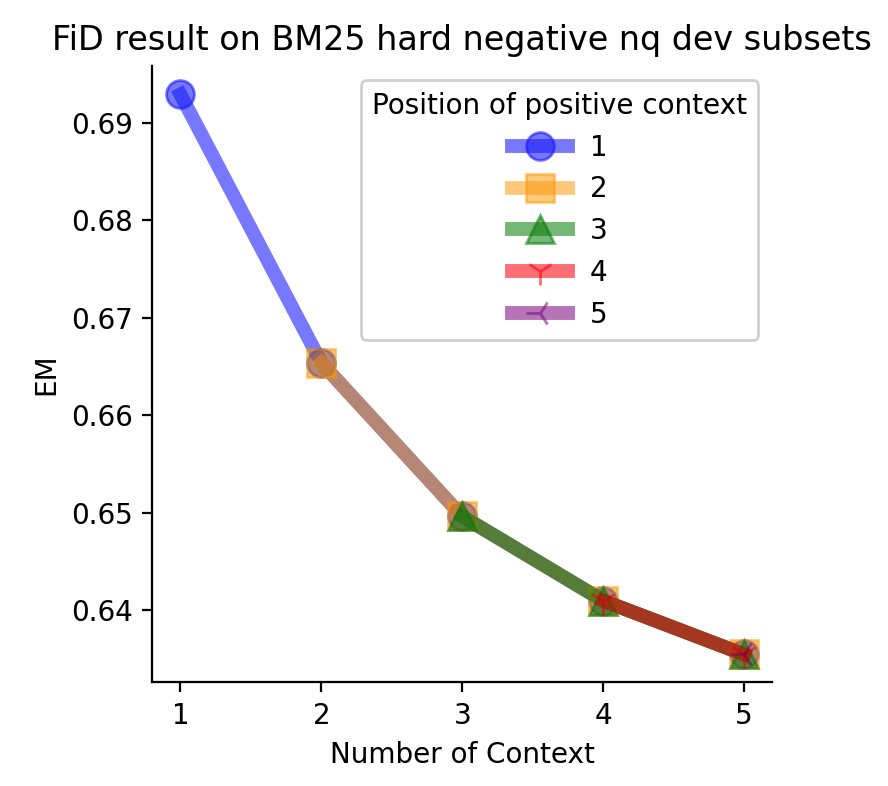

# Next Step

### Step1
- Based on the result, we can now fix the position of positive passage and adding extra samples to get damagae passage samples (Methods part in README.md)

### __Damaging passages__
- Damaging Passage is a concept we want to present.
- Previous works focus on the re-ranking of retrieved passages, which based on the assumption that taking top-k passages with higher similarity scores will show higher performance in the downstream tasks.
- ; however, we have been shown that among those retrieved passages with higher similarity scores actually downgrades the final output which could have been produce the correct answer without them.
- So those passages are what we called damaging passges that have to be removed not just re-ranked by its score.
- Other works are mainly dealing with re-ranking or finding right passages within the retrieved data instead of removing them. 
- Damaging passages acts like false positives in IR.
- So previously, we conceived Corpus(evidence passages) are comprised of relevant passage set and irrelevant passage set in terms of query
- In this Paper, we concived evidence passages are comprised of relevant passages, irrelevant passage, and damaging passages with respect to query.

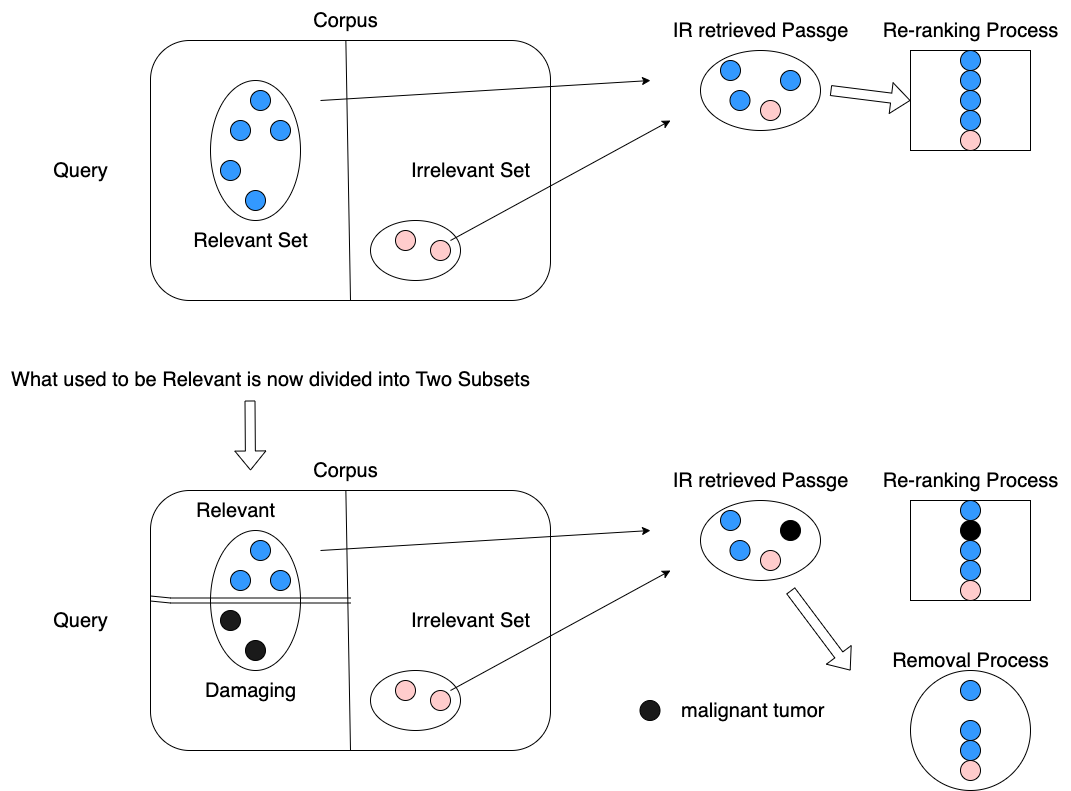

#======

# What Needs to be done?

### By priorities, By resources

## 1. Install Zotero! -- Please do it ASAP!!! 

## 2. (RQ2) Proving Removal Process Assumption __IMPORTANT__
    - How?
        - Remove damaging passages which cause `10` conversion pattern for every instances
        - __I think as k increase performance increases Why? Fid gets better performance with larger pools indicates that positive context is located in the bottom portion of the retrieved list. Yes `01` pattern occurs. So I want them to be in my list for later use, which is training__
        - However, it will took some time... so Set k=5 after removing damaging passges and set attention_ids to 0s when there are absent passages.
        - ``case a`` if the result is somewhere around Oracle setting -> promising
        - ``case b`` __hopefully even higher than Oracle because this Oracle setting uses only 1 gold passges, but if our assumption is correct, we could use 1 gold plus k - 1 positive context(relevant but not damaging which migh give positive supurious cues) which should more powerful(?) than using 1 gold passage__
        - case a) supports our assumption and case b) is be just WOW (superior than Oracle Scenario?)
        
----------------------------------
    - Well... I think above rationale was totally wrong.
    - There will be Upperbound for above setting! Upperbound will be 1 gold passage. (Oracle Scenario)
    - Why? Cause I used the damaged passages only!
- Summary
    - 1 positive setting : `Oracle Setting` 
    - 1 positive + k negative : `Oracle removal setting` 
        - upperbounds would be `Oracle setting` cause I used hard-negative-context passage only(most hard-negative-context are damaging... my guess)
    - 1 positive + k retrieved setting : `Realistic Oracle setting` 
        - The realistic Oracle
    - 1 positive + k retrieved -> removal setting : `Realistic Oracle removal setting` 
        - __The goal of our paper__
        - Lowerbound would be `Realistic Oracle setting` 
        - Upperbounds not limited to `Oracle setting` or even higher but this case is ``case b`` mentioned above: __hopefully even higher than ``Oracle Setting`` because this Oracle setting uses only 1 gold passges, but if our assumption is correct, we could use 1 gold plus extra positive context(relevant but not damaging which migh give positive supurious cues to infer the answer) which should more powerful(?) than using just 1 gold passage__ 
        - as k increases the possibilty of getting right passages increases, since the possilbilty of getting positive contexts is increasing.
    
    
- Methods
    1. Just remove damaging (Use positive + irrelevant cause i think irrelevant has de-noising effect, so FiD will have stronger boudary... my guess)
    2. Remove damaging + irrelevant passages (just use positive)

## 3. Training Neural Classifier
- __Train a neural classifier__
    - Architectures
        - Maybe [Masking] entities are efficient ? (to seperating general knowledge and memory? because damaging vs positive context are very subtle in my concern. depends on the tasks and query as well) for example when query ask birth date of a person, model might confuse with death date because it may focues too much on dates not birth nor death. hmm... need to ask!
        - Biencoder-archticture ?(light-weight?)
        - Distillation ? (Oh, we could train Retrieval to upgrade performance on ruling out damaging passages using distillation just like ETM, ESM model!!!!!). So our removal module acts like a ETM, Retriever can work like ESM) 
        - Linear Classifier
        - Multi-classification (irrelevant, damaging, positive)
        - Score
            - uniform setting
            - linear setting
            - reciprocal setting
            

## Methods.
### Method1. `Oracle removal setting` + Incremental Inference
            - Data: 1 positive + 4 BM25 negatives (KILT_NQ_BM25_DEV)
            - `Use Dev + incremental Oracle (Fastest)`
            - Just use result we've just got (KILT NQ BM25 negative dev subsets)
                - Find the `10` pattern on 1 Oracle + 4 negatives NQ dev subsets 
            - Though small instances but thanks to incremental setting we can have multiple positive/negative training instances! do not need to worry about training examples!
            - My concern is dev set.
            - However, we could divided dev into 9(train):1(dev) for starters!
### Method2. `Realistic Oracle setting` + Incremental Inference -> Use the Train set in KILT
            - ***** Base Training Method *****
            - Data: 1 positive + 99 DPR retrieved list (KILT NQ DPR retrieved)
            - Realistic Scenario 
            - __Takes a bit of time__
            - __But surely need to do it__
            - To do this, we need several steps
            - 1. Using KILT, in this time, using DPR retriever to get the retrieval passages list for question
            - 2. Using KILT, infuse dataset 1 Oracle with this retrieved passage list. 
            - 3. Using that dataset, inferring on train incrementally if possible top-100 
            - 4. Figure out 10 pattern on the 100 results that is a sequence of 0s 1s with length of 100
            - 5. Training Neural Netwrok based on the 4 above.
### Method3. `Realistic Scenario setting` + Incremental Inference -> Use the Train set in KILT
            - Data: DPR retrieved list (KILT NQ DPR retrieved)
            - Realistic Scenario 
            - __Takes a bit of time__
            - __But surely need to do it__
            - To do this, we need several steps
            - 1. Using KILT, in this time, using DPR retriever to get the retrieval passages list for question
            - 2. Using that dataset, inferring on train incrementally if possible top-100 
            - 3. Figure out 10 pattern on the 100 results that is a sequence of 0s 1s with length of 100
            - 4. Training Neural Netwrok based on the 4 above.
            ***** advantage1 ***** : Doing train without labels (Let the model output decides which context is damaging!)
            
### Testing with Other retrievers, GTR, Contriever Needed, etc

#### Advantage 
- advantage 1 : Train without labels in Realistic Scenario setting
- advantage 2 : Reduce the size of input to FiD or to readers
- advantage 3 : Can be applied to any framework (between retriever and reader)
- advantage 4 : If we get certain confidence level, do not check rest of the item, give it to reader

#### Future Works (disadvantages)
- possible disadvantage 1 : dependent on retrievers (explicit upperboud. More precisely, depend on Reader's performance, Better the Retriever, Better the result)
- Which way is better?
    - incorporate damaging filter module to reader side?
    - incorporate damaging filter module to retrieval side?

In [2]:
#         - 1. Since we have KILT retrived nq train/dev set, apply FiD incrementally up to top-100 (for starters let's do with top-20)
#         - 2. Using KILT, infuse dataset 1 Oracle with this retrieved passage list. 
#         - 3. Using that dataset, inferring on train incrementally if possible top-100 
#         - 4. Figure out 10 pattern on the 100 results that is a sequence of 0s 1s with length of 100
#         - 5. Training Neural Netwrok based on the 4 above.
#     - Method2. Use Train + incremental realistic Oracle 
#         - To do this, we need several steps
#         - 1. Using KILT, in this time, using DPR retriever to get the retrieval passages list for question
#         - 2. Using KILT, infuse dataset 1 Oracle with this retrieved passage list. 
#         - 3. Using that dataset, inferring on train incrementally if possible top-100 
#         - 4. Figure out 10 pattern on the 100 results that is a sequence of 0s 1s with length of 100
#         - 5. Training Neural Netwrok based on the 4 above.

# Might be Subject of Next Paper?
- Showing that individual downstream tasks in KILT are different?
- Proving them might give us a hint for dealing with temperality in IR (my guess... Figure out tasks differences and characteristics lead us a way to sovling temperality... I hope... :)

## Scribblings (Jotting down ideas or thoughts during reading papers)
### Each tasks(QA, Fact-Verification, Slot Filling, Dialogue) might need to define their own definition of relevance/damaging passages:
- Example1. (QA setting) Who is the second to last president in the U.S.?
    - p1 : Donald J. Trump was the president of the United States from ~ to ~. -> relevant
    - p2 : Joe.Biden was elected as the president of the United States on ~ . -> damaging
- Example2. (Fact Checking setting) Donald J. Trump is the current president of the United States.
    - p1 : Donald J. Trump was the president of the United States from ~ to ~. -> damaging
    - p2 : Joe.Biden was elected as the president of the United States on ~ . -> relevant

### Suggestion1 : Fine-tuned on Each Task
### Suggestion2 : Multi-tasking Learning
### Suggestion3 : Prompt!